# Gradient boosting regressor

## Imports

In [1]:
import numpy as np
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import root_mean_squared_error
from sklearn import set_config

from utils import PROCESSED_DATA_DIR, VALIDATION_CUTOFF, print_metrics

pl.Config.set_tbl_rows(20)
set_config(transform_output = "pandas")

## Data loading

In [2]:
processed_train_df = pl.read_parquet(
    PROCESSED_DATA_DIR.joinpath('training', 'train_full.parquet')
)

processed_train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0


In [3]:
processed_train_df.describe()

statistic,carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,str,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1698818""",1.698818e6,"""1698818""","""1698818""",1.698818e6,1.698818e6,1.698818e6,1.698818e6,"""1599704""","""1599704""",1.599704e6,1.599704e6,1.599704e6,1.599704e6,1.599704e6,1.599704e6,1.598505e6,1.598505e6,1.698818e6,1.698818e6,1.698818e6
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""99114""","""99114""",99114.0,99114.0,99114.0,99114.0,99114.0,99114.0,100313.0,100313.0,0.0,0.0,0.0
"""mean""",null,5910.75087,"""2018-06-24""","""2018-06-07""",710.461822,17.419005,0.695564,5.91818,"""2018-07-01 06:49:28.030135""","""2018-07-01 08:45:02.581152""",115.57585,-405.751189,0.013588,2.93231,23.034132,5.301361,5721.521024,271.993762,3.944983,3.839782,0.058343
"""std""",null,4285.440264,null,null,543.207638,12.959215,0.460168,2.968049,null,null,62.670552,62.255521,0.115774,1.260417,11.898872,2.971523,2358.75767,63.198466,1.690606,1.631242,0.234391
"""min""","""L1""",174.0,"""2018-01-01""","""2017-11-27""",234.0,0.0,0.0,0.0,"""2018-01-01 05:31:00""","""2018-01-01 07:02:00""",60.0,-480.0,0.0,0.0,2.0,1.0,1378.0,165.0,0.0,0.0,0.0
"""25%""",null,2724.0,"""2018-03-30""","""2018-03-12""",395.0,8.0,0.0,4.0,"""2018-04-04 08:05:00""","""2018-04-04 10:37:00""",78.0,-420.0,0.0,2.0,9.0,3.0,2864.0,223.0,3.0,3.0,0.0
"""50%""",null,5280.0,"""2018-06-08""","""2018-05-22""",552.0,16.0,1.0,6.0,"""2018-06-20 06:05:00""","""2018-06-20 07:57:00""",89.0,-420.0,0.0,3.0,22.0,5.0,7022.0,270.0,4.0,3.0,0.0
"""75%""",null,6759.0,"""2018-09-24""","""2018-09-06""",825.0,26.0,1.0,8.0,"""2018-09-29 10:40:00""","""2018-09-29 12:28:00""",106.0,-360.0,0.0,4.0,35.0,8.0,7578.0,308.0,5.0,5.0,0.0
"""max""","""U3""",29555.0,"""2018-12-31""","""2018-12-31""",7859.0,328.0,1.0,11.0,"""2018-12-31 22:52:00""","""2019-01-01 00:26:00""",304.0,-240.0,1.0,5.0,43.0,12.0,8396.0,423.0,7.0,7.0,1.0


## Data processing

### Train validation split

In [4]:
train_df = processed_train_df.filter(
    pl.col('flt_departure_dt') <= VALIDATION_CUTOFF
)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0


In [5]:
train_df.describe()

statistic,carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,str,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1556671""",1.556671e6,"""1556671""","""1556671""",1.556671e6,1.556671e6,1.556671e6,1.556671e6,"""1460289""","""1460289""",1.460289e6,1.460289e6,1.460289e6,1.460289e6,1.460289e6,1.460289e6,1.456358e6,1.456358e6,1.556671e6,1.556671e6,1.556671e6
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""96382""","""96382""",96382.0,96382.0,96382.0,96382.0,96382.0,96382.0,100313.0,100313.0,0.0,0.0,0.0
"""mean""",null,5911.454399,"""2018-06-08""","""2018-05-22""",698.183723,17.265929,0.759079,5.935386,"""2018-06-15 04:15:06.345305""","""2018-06-15 06:10:36.537699""",115.503207,-401.853921,0.013829,2.936193,23.187674,5.327998,5772.255902,272.205624,3.954633,3.838421,0.061915
"""std""",null,4283.113936,null,null,466.055604,12.725705,0.427643,2.968212,null,null,62.531057,61.484587,0.116783,1.262305,11.932692,2.9922,2377.101806,63.219415,1.691103,1.626951,0.241002
"""min""","""L1""",174.0,"""2018-01-01""","""2017-11-27""",234.0,0.0,0.0,0.0,"""2018-01-01 05:31:00""","""2018-01-01 07:02:00""",60.0,-480.0,0.0,0.0,2.0,1.0,1378.0,165.0,0.0,0.0,0.0
"""25%""",null,2724.0,"""2018-03-26""","""2018-03-09""",395.0,8.0,1.0,4.0,"""2018-03-30 18:40:00""","""2018-03-30 20:37:00""",79.0,-420.0,0.0,2.0,9.0,3.0,2864.0,222.0,3.0,3.0,0.0
"""50%""",null,5274.0,"""2018-05-20""","""2018-05-04""",552.0,16.0,1.0,6.0,"""2018-06-01 22:56:00""","""2018-06-02 00:11:00""",89.0,-420.0,0.0,3.0,23.0,5.0,7054.0,273.0,4.0,3.0,0.0
"""75%""",null,6759.0,"""2018-08-28""","""2018-08-11""",819.0,26.0,1.0,8.0,"""2018-09-03 20:52:00""","""2018-09-03 22:38:00""",105.0,-360.0,0.0,4.0,35.0,8.0,7578.0,308.0,5.0,5.0,0.0
"""max""","""U3""",29555.0,"""2018-11-30""","""2018-11-30""",6354.0,328.0,1.0,11.0,"""2018-11-30 22:45:00""","""2018-12-01 00:02:00""",304.0,-240.0,1.0,5.0,43.0,12.0,8396.0,423.0,7.0,7.0,1.0


In [6]:
val_df = processed_train_df.filter(
    (pl.col('flt_departure_dt') > VALIDATION_CUTOFF) & 
    (
        pl.col('flt_departure_dt') <= (VALIDATION_CUTOFF + pl.duration(days = 7))
    )
)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""L2""",7220,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 10:15:00,2018-12-01 11:27:00,72,-480,0,2,32,9,7128,224,4,3,0
"""L2""",4448,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 08:40:00,2018-12-01 10:04:00,84,-480,0,2,32,9,7128,224,4,3,0
"""L2""",7402,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 14:10:00,2018-12-01 15:22:00,72,-480,0,3,32,9,7128,224,4,3,0
"""L2""",2200,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 19:50:00,2018-12-01 21:02:00,72,-480,0,4,32,10,7128,224,4,3,0
"""L2""",8903,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 22:45:00,2018-12-02 00:02:00,77,-480,1,5,32,1,7128,224,4,3,0
"""L2""",5041,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 12:40:00,2018-12-01 13:52:00,72,-480,0,3,32,9,7128,224,4,3,0
"""L2""",1732,2018-12-01,2018-10-02,395,60,0,6,2018-12-01 16:50:00,2018-12-01 18:02:00,72,-480,0,4,32,10,7128,224,4,3,0
"""L1""",5927,2018-12-01,2018-10-05,530,57,0,1,2018-12-01 20:30:00,2018-12-01 23:37:00,187,-300,0,5,4,1,2164,373,1,5,0
"""L1""",11158,2018-12-01,2018-10-05,800,57,0,1,2018-12-01 12:03:00,2018-12-01 15:20:00,197,-300,0,3,4,1,2164,373,1,5,0


In [7]:
val_df.describe()

statistic,carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,str,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""29492""",29492.0,"""29492""","""29492""",29492.0,29492.0,29492.0,29492.0,"""29462""","""29462""",29462.0,29462.0,29462.0,29462.0,29462.0,29462.0,29492.0,29492.0,29492.0,29492.0,29492.0
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""30""","""30""",30.0,30.0,30.0,30.0,30.0,30.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,5931.477418,"""2018-12-04""","""2018-11-16""",636.639767,17.878611,0.0,5.770005,"""2018-12-04 15:19:48.756364""","""2018-12-04 17:13:48.900956""",114.00241,-447.238477,0.00818,2.917792,22.015613,5.295771,5224.45097,268.025397,3.864946,3.839278,0.001017
"""std""",null,4253.523118,null,null,426.948517,14.627672,0.0,2.947329,null,null,63.011074,54.955176,0.090074,1.230295,12.075227,2.892415,2099.212104,62.301247,1.66831,1.65516,0.031878
"""min""","""L1""",752.0,"""2018-12-01""","""2018-03-04""",263.0,0.0,0.0,0.0,"""2018-12-01 00:40:00""","""2018-12-01 05:34:00""",61.0,-480.0,0.0,0.0,4.0,1.0,1618.0,165.0,0.0,0.0,0.0
"""25%""",null,2667.0,"""2018-12-02""","""2018-11-08""",360.0,8.0,0.0,4.0,"""2018-12-02 19:35:00""","""2018-12-02 21:05:00""",77.0,-480.0,0.0,2.0,8.0,3.0,2790.0,227.0,3.0,3.0,0.0
"""50%""",null,5663.0,"""2018-12-04""","""2018-11-18""",505.0,16.0,0.0,5.0,"""2018-12-04 15:10:00""","""2018-12-04 17:06:00""",85.0,-480.0,0.0,3.0,21.0,5.0,5817.0,253.0,3.0,3.0,0.0
"""75%""",null,7019.0,"""2018-12-06""","""2018-11-26""",724.0,26.0,0.0,7.0,"""2018-12-06 11:05:00""","""2018-12-06 12:38:00""",107.0,-420.0,0.0,4.0,35.0,8.0,7128.0,294.0,5.0,5.0,0.0
"""max""","""U3""",18769.0,"""2018-12-07""","""2018-12-07""",7859.0,276.0,0.0,11.0,"""2018-12-07 22:45:00""","""2018-12-08 00:02:00""",301.0,-300.0,1.0,5.0,37.0,11.0,7128.0,405.0,7.0,7.0,1.0


### Fare rescaling

#### Check if any (`route`, `carrier`) pair is missing in `train_df`

In [8]:
train_df.group_by('route_id', 'carrier').len().drop('len').join(
    val_df.group_by('route_id', 'carrier').len().drop('len'),
    on = ['route_id', 'carrier'],
    how = 'outer'
).null_count()

route_id,carrier,route_id_right,carrier_right
u32,u32,u32,u32
0,0,4,4


#### Calculating range of log of fares by (`route`, `carrier`)

In [9]:
train_df.group_by('route_id', 'carrier').agg(
    (pl.col('total_fare').max() / pl.col('total_fare').mean()).alias('up_range'),
    (pl.col('total_fare').min() / pl.col('total_fare').mean()).alias('down_range')
).describe()

statistic,route_id,carrier,up_range,down_range
str,f64,str,f64,f64
"""count""",34.0,"""34""",34.0,34.0
"""null_count""",0.0,"""0""",0.0,0.0
"""mean""",5.588235,null,4.523691,0.462604
"""std""",3.239132,null,1.945465,0.081088
"""min""",0.0,"""L1""",2.05318,0.278275
"""25%""",3.0,null,2.838609,0.415042
"""50%""",5.0,null,4.284137,0.46635
"""75%""",8.0,null,5.292899,0.521188
"""max""",11.0,"""U3""",9.486336,0.623127


In [10]:
base_log10_fares = train_df.group_by('route_id', 'carrier').agg(
    pl.col('total_fare').log10().mean().alias('base_fare'),
    pl.col('total_fare').log10().std().alias('std_fare'),
    pl.col('total_fare').log10().min().alias('min_fare'),
    pl.col('total_fare').log10().max().alias('max_fare')
).sort('route_id', 'carrier')

base_log10_fares

route_id,carrier,base_fare,std_fare,min_fare,max_fare
u8,str,f64,f64,f64,f64
0,"""L1""",2.877514,0.194479,2.472756,3.764923
0,"""U3""",2.728148,0.140458,2.468347,3.099681
1,"""L1""",2.991069,0.197935,2.638489,3.749659
2,"""L1""",2.931838,0.205985,2.472756,3.725503
2,"""OTH""",2.758927,0.160084,2.448706,3.170555
2,"""U3""",2.701619,0.194855,2.418301,3.237795
3,"""L1""",2.972533,0.216676,2.472756,3.730621
3,"""OTH""",2.763481,0.173673,2.448706,3.170555
3,"""U3""",2.808008,0.214577,2.418301,3.169674


In [11]:
base_log10_fares.select(pl.col(pl.Float64())).describe()

statistic,base_fare,std_fare,min_fare,max_fare
str,f64,f64,f64,f64
"""count""",34.0,34.0,34.0,34.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",2.780166,0.182301,2.481561,3.440914
"""std""",0.131822,0.029635,0.088668,0.251219
"""min""",2.578117,0.11764,2.369216,3.05423
"""25%""",2.671029,0.161205,2.418301,3.24005
"""50%""",2.763481,0.182345,2.472756,3.438226
"""75%""",2.877514,0.20389,2.489958,3.672283
"""max""",3.021101,0.24627,2.669317,3.803047


In [12]:
train_df = train_df.join(
    base_log10_fares.select('route_id', 'carrier', 'base_fare'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('total_fare').log10().alias('log_fare')
).with_columns(
    (
        (pl.col('log_fare') - pl.col('base_fare')) / pl.col('base_fare')
    ).round(4).alias('scaled_fare')
)

train_df['scaled_fare'].describe()

statistic,value
str,f64
"""count""",1.556671e6
"""null_count""",0.0
"""mean""",-0.000001
"""std""",0.068808
"""min""",-0.1681
"""25%""",-0.0505
"""50%""",-0.013
"""75%""",0.0407
"""max""",0.3802


In [13]:
val_df = val_df.join(
    base_log10_fares.select('route_id', 'carrier', 'base_fare'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('total_fare').log10().alias('log_fare')
).with_columns(
    (
        (pl.col('log_fare') - pl.col('base_fare')) / pl.col('base_fare')
    ).round(4).alias('scaled_fare')
)

val_df['scaled_fare'].describe()

statistic,value
str,f64
"""count""",29492.0
"""null_count""",0.0
"""mean""",-0.017314
"""std""",0.070193
"""min""",-0.1681
"""25%""",-0.0707
"""50%""",-0.0312
"""75%""",0.0229
"""max""",0.5109


In [14]:
train_df.sort('scaled_fare')

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64
"""L1""",6523,2018-03-06,2018-02-26,297,8,0,3,2018-03-06 06:00:00,2018-03-06 10:58:00,298,-480,0,1,8,1,2873,392,3,2,0,2.972533,2.472756,-0.1681
"""L1""",6523,2018-03-06,2018-02-27,297,7,0,3,2018-03-06 06:00:00,2018-03-06 10:58:00,298,-480,0,1,8,1,2873,392,3,2,0,2.972533,2.472756,-0.1681
"""L1""",5663,2018-03-09,2018-02-25,297,12,0,3,2018-03-09 12:17:00,2018-03-09 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.972533,2.472756,-0.1681
"""L1""",5663,2018-03-09,2018-02-26,297,11,0,3,2018-03-09 12:17:00,2018-03-09 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.972533,2.472756,-0.1681
"""L1""",3861,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 15:55:00,2018-03-10 20:52:00,297,-480,0,3,8,3,2873,392,3,2,0,2.972533,2.472756,-0.1681
"""L1""",5663,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 12:17:00,2018-03-10 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.972533,2.472756,-0.1681
"""L1""",6523,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 06:05:00,2018-03-10 11:03:00,298,-480,0,1,8,1,2873,392,3,2,0,2.972533,2.472756,-0.1681
"""L1""",6294,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 13:45:00,2018-03-10 18:43:00,298,-480,0,3,8,3,2873,392,3,2,0,2.972533,2.472756,-0.1681
"""L1""",6523,2018-03-10,2018-02-24,297,14,0,3,2018-03-10 06:05:00,2018-03-10 11:03:00,298,-480,0,1,8,1,2873,392,3,2,0,2.972533,2.472756,-0.1681


In [15]:
val_df.sort('scaled_fare')

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64
"""L1""",2149,2018-12-04,2018-11-13,297,21,0,3,2018-12-04 01:05:00,2018-12-04 05:59:00,294,-480,0,0,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681
"""L1""",2149,2018-12-05,2018-10-24,297,42,0,3,2018-12-05 01:05:00,2018-12-05 05:59:00,294,-480,0,0,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681
"""L1""",2149,2018-12-05,2018-10-27,297,39,0,3,2018-12-05 01:05:00,2018-12-05 05:59:00,294,-480,0,0,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681
"""L1""",2149,2018-12-05,2018-10-31,297,35,0,3,2018-12-05 01:05:00,2018-12-05 05:59:00,294,-480,0,0,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681
"""L1""",2149,2018-12-05,2018-11-01,297,34,0,3,2018-12-05 01:05:00,2018-12-05 05:59:00,294,-480,0,0,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681
"""L1""",2149,2018-12-05,2018-11-02,297,33,0,3,2018-12-05 01:05:00,2018-12-05 05:59:00,294,-480,0,0,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681
"""L1""",2149,2018-12-05,2018-11-04,297,31,0,3,2018-12-05 01:05:00,2018-12-05 05:59:00,294,-480,0,0,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681
"""L1""",6523,2018-12-05,2018-11-12,297,23,0,3,2018-12-05 06:00:00,2018-12-05 10:51:00,291,-480,0,1,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681
"""L1""",2149,2018-12-05,2018-11-13,297,22,0,3,2018-12-05 01:05:00,2018-12-05 05:59:00,294,-480,0,0,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681


### Feature generation

#### Last week prices

In [16]:
route_mean_fares = train_df.group_by('route_id').agg(
    pl.col('total_fare').mean().alias('route_mean_fare')
).sort('route_id')

route_mean_fares

route_id,route_mean_fare
u8,f64
0,783.14774
1,1097.415019
2,868.048674
3,952.040323
4,556.355987
5,701.940073
6,514.156024
7,767.79568
8,1181.633669


In [17]:
route_week_ago_fare = processed_train_df.group_by(
    'route_id', 'flt_departure_dt'
).agg(
    pl.col('total_fare').mean()
).with_columns(
    pl.col('flt_departure_dt') + pl.duration(days = 7)
).join(
    route_mean_fares,
    on = "route_id",
    how = "left"
).select(
    pl.col('route_id'),
    pl.col('flt_departure_dt'),
    (
        pl.col('total_fare') / pl.col('route_mean_fare')
    ).alias('7d_route_avg')
).sort('route_id', 'flt_departure_dt')

route_week_ago_fare

route_id,flt_departure_dt,7d_route_avg
u8,date,f64
0,2018-02-17,0.944266
0,2018-02-18,0.944266
0,2018-02-19,0.944139
0,2018-02-20,0.944266
0,2018-02-21,0.944266
0,2018-02-22,1.0408
0,2018-02-23,0.993722
0,2018-02-24,0.92158
0,2018-02-25,0.90173


In [18]:
route_2week_ago_fare = processed_train_df.group_by(
    'route_id', 'flt_departure_dt'
).agg(
    pl.col('total_fare').mean()
).with_columns(
    pl.col('flt_departure_dt') + pl.duration(days = 14)
).join(
    route_mean_fares,
    on = "route_id",
    how = "left"
).select(
    pl.col('route_id'),
    pl.col('flt_departure_dt'),
    (
        pl.col('total_fare') / pl.col('route_mean_fare')
    ).alias('14d_route_avg')
).sort('route_id', 'flt_departure_dt')

route_2week_ago_fare

route_id,flt_departure_dt,14d_route_avg
u8,date,f64
0,2018-02-24,0.944266
0,2018-02-25,0.944266
0,2018-02-26,0.944139
0,2018-02-27,0.944266
0,2018-02-28,0.944266
0,2018-03-01,1.0408
0,2018-03-02,0.993722
0,2018-03-03,0.92158
0,2018-03-04,0.90173


In [19]:
route_carrier_mean_fares = train_df.group_by('route_id', 'carrier').agg(
    pl.col('total_fare').mean().alias('route_carrier_mean_fare')
).sort('route_id', 'carrier')

route_carrier_mean_fares

route_id,carrier,route_carrier_mean_fare
u8,str,f64
0,"""L1""",844.096034
0,"""U3""",564.095514
1,"""L1""",1097.415019
2,"""L1""",965.296259
2,"""OTH""",615.358735
2,"""U3""",559.28629
3,"""L1""",1067.290113
3,"""OTH""",629.309001
3,"""U3""",719.858787


In [20]:
route_carrier_week_ago_fare = processed_train_df.group_by(
    'route_id', 'flt_departure_dt', 'carrier'
).agg(
    pl.col('total_fare').mean()
).with_columns(
    pl.col('flt_departure_dt') + pl.duration(days = 7)
).join(
    route_carrier_mean_fares,
    on = ['route_id', 'carrier'],
    how = "left"
).select(
    pl.col('route_id'),
    pl.col('flt_departure_dt'),
    pl.col('carrier'),
    (
        pl.col('total_fare') / pl.col('route_carrier_mean_fare')
    ).alias('7d_route_carrier_avg')
).sort('route_id', 'flt_departure_dt', 'carrier')

route_carrier_week_ago_fare

route_id,flt_departure_dt,carrier,7d_route_carrier_avg
u8,date,str,f64
0,2018-02-17,"""U3""",1.310948
0,2018-02-18,"""U3""",1.310948
0,2018-02-19,"""U3""",1.310771
0,2018-02-20,"""U3""",1.310948
0,2018-02-21,"""U3""",1.310948
0,2018-02-22,"""U3""",1.444968
0,2018-02-23,"""U3""",1.379608
0,2018-02-24,"""U3""",1.279452
0,2018-02-25,"""U3""",1.251893


In [21]:
train_df = train_df.join(
    route_week_ago_fare,
    on = ['route_id', 'flt_departure_dt'],
    how = 'left'
).join(
    route_2week_ago_fare,
    on = ['route_id', 'flt_departure_dt'],
    how = 'left'
).join(
    route_carrier_week_ago_fare,
    on = ['route_id', 'flt_departure_dt', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('7d_route_avg').fill_null(1),
    pl.col('14d_route_avg').fill_null(1),
    pl.col('7d_route_carrier_avg').fill_null(1)
)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1,2.755964,2.671173,-0.0308,1.0,1.0,1.0
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0,2.991069,3.04883,0.0193,1.0,1.0,1.0
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0,2.733692,2.625312,-0.0396,1.0,1.0,1.0
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0,2.589739,2.895975,0.1182,1.0,1.0,1.0
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0,2.763495,3.113275,0.1266,1.0,1.0,1.0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0,2.766269,2.570543,-0.0708,1.0,1.0,1.0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1,2.638819,2.710117,0.027,1.0,1.0,1.0
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0,2.578117,2.635484,0.0223,1.0,1.0,1.0
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0,2.72979,2.532754,-0.0722,1.0,1.0,1.0


In [22]:
val_df = val_df.join(
    route_week_ago_fare,
    on = ['route_id', 'flt_departure_dt'],
    how = 'left'
).join(
    route_2week_ago_fare,
    on = ['route_id', 'flt_departure_dt'],
    how = 'left'
).join(
    route_carrier_week_ago_fare,
    on = ['route_id', 'flt_departure_dt', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('7d_route_avg').fill_null(1),
    pl.col('14d_route_avg').fill_null(1),
    pl.col('7d_route_carrier_avg').fill_null(1)
)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64
"""L2""",7220,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 10:15:00,2018-12-01 11:27:00,72,-480,0,2,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,1.179192,0.996404,0.931051
"""L2""",4448,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 08:40:00,2018-12-01 10:04:00,84,-480,0,2,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,1.179192,0.996404,0.931051
"""L2""",7402,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 14:10:00,2018-12-01 15:22:00,72,-480,0,3,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,1.179192,0.996404,0.931051
"""L2""",2200,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 19:50:00,2018-12-01 21:02:00,72,-480,0,4,32,10,7128,224,4,3,0,2.660753,2.454845,-0.0774,1.179192,0.996404,0.931051
"""L2""",8903,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 22:45:00,2018-12-02 00:02:00,77,-480,1,5,32,1,7128,224,4,3,0,2.660753,2.454845,-0.0774,1.179192,0.996404,0.931051
"""L2""",5041,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 12:40:00,2018-12-01 13:52:00,72,-480,0,3,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,1.179192,0.996404,0.931051
"""L2""",1732,2018-12-01,2018-10-02,395,60,0,6,2018-12-01 16:50:00,2018-12-01 18:02:00,72,-480,0,4,32,10,7128,224,4,3,0,2.660753,2.596597,-0.0241,1.179192,0.996404,0.931051
"""L1""",5927,2018-12-01,2018-10-05,530,57,0,1,2018-12-01 20:30:00,2018-12-01 23:37:00,187,-300,0,5,4,1,2164,373,1,5,0,2.991069,2.724276,-0.0892,1.68593,0.848971,1.68593
"""L1""",11158,2018-12-01,2018-10-05,800,57,0,1,2018-12-01 12:03:00,2018-12-01 15:20:00,197,-300,0,3,4,1,2164,373,1,5,0,2.991069,2.90309,-0.0294,1.68593,0.848971,1.68593


#### Days since start

In [23]:
train_df = train_df.with_columns(
    (
        pl.col('flt_departure_dt') - train_df['flt_departure_dt'].min()
    ).dt.total_days().alias("days_since_start")
)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64,i64
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1,2.755964,2.671173,-0.0308,1.0,1.0,1.0,0
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0,2.991069,3.04883,0.0193,1.0,1.0,1.0,0
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0,2.733692,2.625312,-0.0396,1.0,1.0,1.0,0
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0,2.589739,2.895975,0.1182,1.0,1.0,1.0,0
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0,2.763495,3.113275,0.1266,1.0,1.0,1.0,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0,2.766269,2.570543,-0.0708,1.0,1.0,1.0,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1,2.638819,2.710117,0.027,1.0,1.0,1.0,0
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0,2.578117,2.635484,0.0223,1.0,1.0,1.0,0
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0,2.72979,2.532754,-0.0722,1.0,1.0,1.0,0


In [24]:
val_df = val_df.with_columns(
    (
        pl.col('flt_departure_dt') - train_df['flt_departure_dt'].min()
    ).dt.total_days().alias("days_since_start")
)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64,i64
"""L2""",7220,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 10:15:00,2018-12-01 11:27:00,72,-480,0,2,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,1.179192,0.996404,0.931051,334
"""L2""",4448,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 08:40:00,2018-12-01 10:04:00,84,-480,0,2,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,1.179192,0.996404,0.931051,334
"""L2""",7402,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 14:10:00,2018-12-01 15:22:00,72,-480,0,3,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,1.179192,0.996404,0.931051,334
"""L2""",2200,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 19:50:00,2018-12-01 21:02:00,72,-480,0,4,32,10,7128,224,4,3,0,2.660753,2.454845,-0.0774,1.179192,0.996404,0.931051,334
"""L2""",8903,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 22:45:00,2018-12-02 00:02:00,77,-480,1,5,32,1,7128,224,4,3,0,2.660753,2.454845,-0.0774,1.179192,0.996404,0.931051,334
"""L2""",5041,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 12:40:00,2018-12-01 13:52:00,72,-480,0,3,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,1.179192,0.996404,0.931051,334
"""L2""",1732,2018-12-01,2018-10-02,395,60,0,6,2018-12-01 16:50:00,2018-12-01 18:02:00,72,-480,0,4,32,10,7128,224,4,3,0,2.660753,2.596597,-0.0241,1.179192,0.996404,0.931051,334
"""L1""",5927,2018-12-01,2018-10-05,530,57,0,1,2018-12-01 20:30:00,2018-12-01 23:37:00,187,-300,0,5,4,1,2164,373,1,5,0,2.991069,2.724276,-0.0892,1.68593,0.848971,1.68593,334
"""L1""",11158,2018-12-01,2018-10-05,800,57,0,1,2018-12-01 12:03:00,2018-12-01 15:20:00,197,-300,0,3,4,1,2164,373,1,5,0,2.991069,2.90309,-0.0294,1.68593,0.848971,1.68593,334


#### Flight date features

In [25]:
train_df = train_df.with_columns(
    pl.col('flt_departure_dt').dt.month().alias('flt_departure_month'),
    pl.col('flt_departure_dt').dt.day().alias('flt_departure_day'),
    pl.col('flt_departure_dt').dt.week().alias('flt_departure_week'),    
    pl.col('flt_departure_dt').dt.weekday().alias('flt_departure_weekday')  
)
train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64,i64,i8,i8,i8,i8
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1,2.755964,2.671173,-0.0308,1.0,1.0,1.0,0,1,1,1,1
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0,2.991069,3.04883,0.0193,1.0,1.0,1.0,0,1,1,1,1
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0,2.733692,2.625312,-0.0396,1.0,1.0,1.0,0,1,1,1,1
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0,2.589739,2.895975,0.1182,1.0,1.0,1.0,0,1,1,1,1
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0,2.763495,3.113275,0.1266,1.0,1.0,1.0,0,1,1,1,1
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0,2.766269,2.570543,-0.0708,1.0,1.0,1.0,0,1,1,1,1
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1,2.638819,2.710117,0.027,1.0,1.0,1.0,0,1,1,1,1
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0,2.578117,2.635484,0.0223,1.0,1.0,1.0,0,1,1,1,1
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0,2.72979,2.532754,-0.0722,1.0,1.0,1.0,0,1,1,1,1


In [26]:
val_df = val_df.with_columns(
    pl.col('flt_departure_dt').dt.month().alias('flt_departure_month'),
    pl.col('flt_departure_dt').dt.day().alias('flt_departure_day'),
    pl.col('flt_departure_dt').dt.week().alias('flt_departure_week'),    
    pl.col('flt_departure_dt').dt.weekday().alias('flt_departure_weekday')  
)
val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64,i64,i8,i8,i8,i8
"""L2""",7220,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 10:15:00,2018-12-01 11:27:00,72,-480,0,2,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,1.179192,0.996404,0.931051,334,12,1,48,6
"""L2""",4448,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 08:40:00,2018-12-01 10:04:00,84,-480,0,2,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,1.179192,0.996404,0.931051,334,12,1,48,6
"""L2""",7402,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 14:10:00,2018-12-01 15:22:00,72,-480,0,3,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,1.179192,0.996404,0.931051,334,12,1,48,6
"""L2""",2200,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 19:50:00,2018-12-01 21:02:00,72,-480,0,4,32,10,7128,224,4,3,0,2.660753,2.454845,-0.0774,1.179192,0.996404,0.931051,334,12,1,48,6
"""L2""",8903,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 22:45:00,2018-12-02 00:02:00,77,-480,1,5,32,1,7128,224,4,3,0,2.660753,2.454845,-0.0774,1.179192,0.996404,0.931051,334,12,1,48,6
"""L2""",5041,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 12:40:00,2018-12-01 13:52:00,72,-480,0,3,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,1.179192,0.996404,0.931051,334,12,1,48,6
"""L2""",1732,2018-12-01,2018-10-02,395,60,0,6,2018-12-01 16:50:00,2018-12-01 18:02:00,72,-480,0,4,32,10,7128,224,4,3,0,2.660753,2.596597,-0.0241,1.179192,0.996404,0.931051,334,12,1,48,6
"""L1""",5927,2018-12-01,2018-10-05,530,57,0,1,2018-12-01 20:30:00,2018-12-01 23:37:00,187,-300,0,5,4,1,2164,373,1,5,0,2.991069,2.724276,-0.0892,1.68593,0.848971,1.68593,334,12,1,48,6
"""L1""",11158,2018-12-01,2018-10-05,800,57,0,1,2018-12-01 12:03:00,2018-12-01 15:20:00,197,-300,0,3,4,1,2164,373,1,5,0,2.991069,2.90309,-0.0294,1.68593,0.848971,1.68593,334,12,1,48,6


### Imputation

#### Null counts

In [27]:
train_df.null_count()

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,96382,96382,96382,96382,96382,96382,96382,96382,100313,100313,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
val_df.null_count()

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,30,30,30,30,30,30,30,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Flight duration

In [29]:
mean_durations = train_df.group_by('route_id', 'carrier').agg(
    pl.col('dur_min').mean().round(2).alias("dur_mean"),
    pl.col('dur_min').std().round(2).alias("dur_std")
).sort('route_id', 'carrier')

mean_durations

route_id,carrier,dur_mean,dur_std
u8,str,f64,f64
0,"""L1""",190.82,5.32
0,"""U3""",193.89,3.55
1,"""L1""",187.99,14.32
2,"""L1""",77.39,7.55
2,"""OTH""",73.2,7.75
2,"""U3""",94.24,1.8
3,"""L1""",296.7,3.88
3,"""OTH""",297.0,3.37
3,"""U3""",301.47,1.35


In [30]:
train_df = train_df.join(
    mean_durations.drop('dur_std'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.coalesce(['dur_min', 'dur_mean'])
)

train_df['dur_min'].null_count()

0

In [31]:
val_df = val_df.join(
    mean_durations.drop('dur_std'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.coalesce(['dur_min', 'dur_mean'])
)

val_df['dur_min'].null_count()

0

#### Over midnight

In [32]:
train_df = train_df.with_columns(
    pl.col('over_mn').fill_null(-1)
)

train_df['over_mn'].value_counts()

over_mn,count
i8,u32
0,1440094
1,20195
-1,96382


In [33]:
val_df = val_df.with_columns(
    pl.col('over_mn').fill_null(-1)
)

val_df['over_mn'].value_counts()

over_mn,count
i8,u32
1,241
0,29221
-1,30


#### Flight counts

In [34]:
flight_counts_daily = processed_train_df.filter(
    pl.col('flt_count_dpt_24h').is_not_null()
).group_by(
    'flt_departure_dt', 'route_id'
).agg(
    pl.col('flt_count_dpt_24h').first()
).sort('flt_departure_dt', 'route_id')

flight_counts_daily

flt_departure_dt,route_id,flt_count_dpt_24h
date,u8,u8
2018-01-01,1,5
2018-01-01,4,30
2018-01-01,6,30
2018-01-01,8,4
2018-01-01,9,7
2018-01-01,11,21
2018-01-02,1,5
2018-01-02,4,30
2018-01-02,6,30


In [35]:
train_df = train_df.join(
    flight_counts_daily,
    on = ['flt_departure_dt', 'route_id'],
    how = "left"
).with_columns(
    pl.coalesce(['flt_count_dpt_24h', 'flt_count_dpt_24h_right']),
    pl.col('flt_count_dpt_4h').fill_null(-1),
    pl.col('dpt_4h_od').fill_null(-1)
).drop('flt_count_dpt_24h_right')

train_df.select(
    pl.col('flt_count_dpt_24h', 'flt_count_dpt_4h', 'dpt_4h_od').null_count()
)

flt_count_dpt_24h,flt_count_dpt_4h,dpt_4h_od
u32,u32,u32
0,0,0


In [36]:
val_df = val_df.join(
    flight_counts_daily,
    on = ['flt_departure_dt', 'route_id'],
    how = "left"
).with_columns(
    pl.coalesce(['flt_count_dpt_24h', 'flt_count_dpt_24h_right']),
    pl.col('flt_count_dpt_4h').fill_null(-1),
    pl.col('dpt_4h_od').fill_null(-1)
).drop('flt_count_dpt_24h_right')

val_df.select(
    pl.col('flt_count_dpt_24h', 'flt_count_dpt_4h', 'dpt_4h_od').null_count()
)

flt_count_dpt_24h,flt_count_dpt_4h,dpt_4h_od
u32,u32,u32
0,0,0


### Training datasets

In [37]:
TRAINING_COLS = [
    'carrier', 'days_till_flight', 'origin_id', 'destination_id', 'route_id',
    'dur_min', 'flt_info_null', 'days_since_start', 'is_dst',
    'flt_departure_month', 'flt_departure_day',
    'flt_departure_week', 'flt_departure_weekday',
    '7d_route_avg', '14d_route_avg', '7d_route_carrier_avg', 'over_mn',
    'flt_count_dpt_24h', 'flt_count_dpt_4h', 'dpt_4h_od'
]

X_train = train_df.select(TRAINING_COLS)
X_val = val_df.select(TRAINING_COLS)

y_train = train_df['scaled_fare']
y_val = val_df['scaled_fare']

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1556671, 20), (29492, 20), (1556671,), (29492,))

In [38]:
X_train.describe()

statistic,carrier,days_till_flight,origin_id,destination_id,route_id,dur_min,flt_info_null,days_since_start,is_dst,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,7d_route_avg,14d_route_avg,7d_route_carrier_avg,over_mn,flt_count_dpt_24h,flt_count_dpt_4h,dpt_4h_od
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1556671""",1.556671e6,1.556671e6,1.556671e6,1.556671e6,1.556671e6,1.556671e6,1.556671e6,1.556671e6,1.556671e6,1.556671e6,1.556671e6,1.556671e6,1.556671e6,1.556671e6,1.556671e6,1.556671e6,1.556671e6,1.556671e6,1.556671e6
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,17.265929,3.954633,3.838421,5.935386,113.770862,0.061915,158.740897,0.759079,5.76818,15.667422,23.250227,3.989309,1.00659,1.006215,1.008206,-0.048942,23.438395,4.936197,2.692482
"""std""",null,12.725705,1.691103,1.626951,2.968212,60.984253,0.241002,92.095246,0.427643,3.013548,8.7547,13.161716,1.998812,0.321856,0.324903,0.341546,0.269246,11.723448,3.274862,1.547468
"""min""","""L1""",0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.452164,0.452164,0.43012,-1.0,2.0,-1.0,-1.0
"""25%""",null,8.0,3.0,3.0,4.0,79.0,0.0,84.0,1.0,3.0,8.0,13.0,2.0,0.803245,0.803705,0.796147,0.0,9.0,2.0,2.0
"""50%""",null,16.0,4.0,3.0,6.0,90.0,0.0,139.0,1.0,5.0,16.0,20.0,4.0,0.930686,0.932234,0.925562,0.0,23.0,5.0,3.0
"""75%""",null,26.0,5.0,5.0,8.0,102.0,0.0,239.0,1.0,8.0,23.0,35.0,6.0,1.113075,1.102213,1.118423,0.0,35.0,8.0,4.0
"""max""","""U3""",328.0,7.0,7.0,11.0,304.0,1.0,333.0,1.0,11.0,31.0,48.0,7.0,4.960616,4.960616,4.883298,1.0,43.0,12.0,5.0


In [39]:
X_val.describe()

statistic,carrier,days_till_flight,origin_id,destination_id,route_id,dur_min,flt_info_null,days_since_start,is_dst,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,7d_route_avg,14d_route_avg,7d_route_carrier_avg,over_mn,flt_count_dpt_24h,flt_count_dpt_4h,dpt_4h_od
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""29492""",29492.0,29492.0,29492.0,29492.0,29492.0,29492.0,29492.0,29492.0,29492.0,29492.0,29492.0,29492.0,29492.0,29492.0,29492.0,29492.0,29492.0,29492.0,29492.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,17.878611,3.864946,3.839278,5.770005,113.968694,0.001017,337.069917,0.0,12.0,4.069917,48.727316,3.978706,1.138156,1.109976,1.124204,0.007154,22.025634,5.289367,2.913807
"""std""",null,14.627672,1.66831,1.65516,2.947329,62.988338,0.031878,1.992678,0.0,0.0,1.992678,0.445347,1.995592,0.454317,0.240076,0.494194,0.095593,12.074201,2.897902,1.235995
"""min""","""L1""",0.0,0.0,0.0,0.0,61.0,0.0,334.0,0.0,12.0,1.0,48.0,1.0,0.620425,0.686443,0.564198,-1.0,4.0,-1.0,-1.0
"""25%""",null,8.0,3.0,3.0,4.0,77.0,0.0,335.0,0.0,12.0,2.0,48.0,2.0,0.838411,0.95073,0.800935,0.0,8.0,3.0,2.0
"""50%""",null,16.0,3.0,3.0,5.0,85.0,0.0,337.0,0.0,12.0,4.0,49.0,4.0,0.974839,1.081598,0.964027,0.0,21.0,5.0,3.0
"""75%""",null,26.0,5.0,5.0,7.0,106.0,0.0,339.0,0.0,12.0,6.0,49.0,6.0,1.28687,1.221928,1.307751,0.0,35.0,8.0,4.0
"""max""","""U3""",276.0,7.0,7.0,11.0,301.0,1.0,340.0,0.0,12.0,7.0,49.0,7.0,2.362383,1.687138,3.023078,1.0,37.0,11.0,5.0


## Modelling

### Training

In [40]:
pred_fare_expr = pl.lit(10).pow(
    (pl.col('pred_scaled_fare') * pl.col('base_fare')) + pl.col('base_fare')
).alias('pred_fare')

def get_model():
    col_transform = ColumnTransformer(
        [
            (
                'ord', 
                OrdinalEncoder(),
                ['carrier']
            )
        ],
        remainder = 'passthrough',
        sparse_threshold = 0
    )
    
    return Pipeline(
        [
            ('col_transformer', col_transform),
            (
                'gbr', 
                GradientBoostingRegressor(
                    max_depth = 4,
                    random_state = 7
                )
            )
        ]
    )

def train_model(param_grid, n_iter = 5):
    param_sampler = ParameterSampler(
        param_grid,
        n_iter = n_iter,
        random_state = 7
    )

    best_rmse = float('inf')
    best_model = None
    best_params = None

    for i, params in enumerate(list(param_sampler)):
        print(f"{params}")
        model = get_model()
        model.set_params(**params)
        model.fit(X_train, y_train)

        val_preds = val_df.with_columns(
            pred_scaled_fare = model.predict(X_val)
        ).with_columns(pred_fare_expr)['pred_fare']

        rmse = root_mean_squared_error(val_df['total_fare'], val_preds)
        print(f"{i} : {rmse:.3f}\n")
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_params = params

    print(f"Best params:\n{best_params}")
    return best_model

param_grid = {
    "gbr__loss": ['squared_error', 'absolute_error'],
    "gbr__n_estimators": np.linspace(150, 300, 4, dtype = np.int32),
    "gbr__learning_rate": [0.01, 0.02, 0.05, 0.1, 0.2]
}

best_model = train_model(param_grid, n_iter = 8)
best_model

{'gbr__n_estimators': 200, 'gbr__loss': 'squared_error', 'gbr__learning_rate': 0.05}
0 : 327.012

{'gbr__n_estimators': 200, 'gbr__loss': 'absolute_error', 'gbr__learning_rate': 0.2}
1 : 310.545

{'gbr__n_estimators': 250, 'gbr__loss': 'squared_error', 'gbr__learning_rate': 0.2}
2 : 417.232

{'gbr__n_estimators': 250, 'gbr__loss': 'squared_error', 'gbr__learning_rate': 0.05}
3 : 329.883

{'gbr__n_estimators': 150, 'gbr__loss': 'squared_error', 'gbr__learning_rate': 0.2}
4 : 398.114

{'gbr__n_estimators': 200, 'gbr__loss': 'squared_error', 'gbr__learning_rate': 0.01}
5 : 317.800

{'gbr__n_estimators': 250, 'gbr__loss': 'absolute_error', 'gbr__learning_rate': 0.05}
6 : 296.264

{'gbr__n_estimators': 250, 'gbr__loss': 'squared_error', 'gbr__learning_rate': 0.01}
7 : 314.173

Best params:
{'gbr__n_estimators': 250, 'gbr__loss': 'absolute_error', 'gbr__learning_rate': 0.05}


Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('ord', OrdinalEncoder(),
                                                  ['carrier'])])),
                ('gbr',
                 GradientBoostingRegressor(learning_rate=0.05,
                                           loss='absolute_error', max_depth=4,
                                           n_estimators=250, random_state=7))])

### Predictions

In [41]:
train_df = train_df.with_columns(
    pred_scaled_fare = best_model.predict(X_train)
).with_columns(pred_fare_expr)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,dur_mean,pred_scaled_fare,pred_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],f64,i16,i8,i8,u8,i16,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64,i64,i8,i8,i8,i8,f64,f64,f64
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,94.43,null,-1,-1,21,-1,null,null,7,3,1,2.755964,2.671173,-0.0308,1.0,1.0,1.0,0,1,1,1,1,94.43,-0.026428,482.090294
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197.0,-300,0,5,5,1,1468,360,1,5,0,2.991069,3.04883,0.0193,1.0,1.0,1.0,0,1,1,1,1,187.99,-0.03959,745.849752
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75.0,-480,0,3,30,9,6659,228,4,3,0,2.733692,2.625312,-0.0396,1.0,1.0,1.0,0,1,1,1,1,78.38,0.004194,556.10393
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84.0,-480,0,5,30,4,6659,316,3,4,0,2.589739,2.895975,0.1182,1.0,1.0,1.0,0,1,1,1,1,81.52,-0.01839,348.427923
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83.0,-480,0,2,30,5,6659,231,3,4,0,2.763495,3.113275,0.1266,1.0,1.0,1.0,0,1,1,1,1,79.11,0.005888,602.237141
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93.0,-480,0,4,21,7,6579,262,7,3,0,2.766269,2.570543,-0.0708,1.0,1.0,1.0,0,1,1,1,1,95.27,-0.03994,452.673849
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,80.14,null,-1,-1,30,-1,null,null,3,4,1,2.638819,2.710117,0.027,1.0,1.0,1.0,0,1,1,1,1,80.14,-0.002394,429.04332
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72.0,-480,0,3,30,9,6659,316,4,3,0,2.578117,2.635484,0.0223,1.0,1.0,1.0,0,1,1,1,1,71.32,0.006842,394.236079
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88.0,-480,0,4,21,7,6579,354,7,3,0,2.72979,2.532754,-0.0722,1.0,1.0,1.0,0,1,1,1,1,90.69,-0.036007,428.054695


In [42]:
val_df = val_df.with_columns(
    pred_scaled_fare = best_model.predict(X_val)
).with_columns(pred_fare_expr)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,7d_route_avg,14d_route_avg,7d_route_carrier_avg,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,dur_mean,pred_scaled_fare,pred_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],f64,i16,i8,i8,u8,i16,i64,i64,u8,u8,u8,f64,f64,f64,f64,f64,f64,i64,i8,i8,i8,i8,f64,f64,f64
"""L2""",7220,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 10:15:00,2018-12-01 11:27:00,72.0,-480,0,2,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,1.179192,0.996404,0.931051,334,12,1,48,6,78.3,0.007373,479.039565
"""L2""",4448,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 08:40:00,2018-12-01 10:04:00,84.0,-480,0,2,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,1.179192,0.996404,0.931051,334,12,1,48,6,78.3,0.009538,485.434353
"""L2""",7402,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 14:10:00,2018-12-01 15:22:00,72.0,-480,0,3,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,1.179192,0.996404,0.931051,334,12,1,48,6,78.3,0.007373,479.039565
"""L2""",2200,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 19:50:00,2018-12-01 21:02:00,72.0,-480,0,4,32,10,7128,224,4,3,0,2.660753,2.454845,-0.0774,1.179192,0.996404,0.931051,334,12,1,48,6,78.3,-0.013223,422.250982
"""L2""",8903,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 22:45:00,2018-12-02 00:02:00,77.0,-480,1,5,32,1,7128,224,4,3,0,2.660753,2.454845,-0.0774,1.179192,0.996404,0.931051,334,12,1,48,6,78.3,-0.030263,380.391492
"""L2""",5041,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 12:40:00,2018-12-01 13:52:00,72.0,-480,0,3,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,1.179192,0.996404,0.931051,334,12,1,48,6,78.3,0.007373,479.039565
"""L2""",1732,2018-12-01,2018-10-02,395,60,0,6,2018-12-01 16:50:00,2018-12-01 18:02:00,72.0,-480,0,4,32,10,7128,224,4,3,0,2.660753,2.596597,-0.0241,1.179192,0.996404,0.931051,334,12,1,48,6,78.3,-0.013223,422.250982
"""L1""",5927,2018-12-01,2018-10-05,530,57,0,1,2018-12-01 20:30:00,2018-12-01 23:37:00,187.0,-300,0,5,4,1,2164,373,1,5,0,2.991069,2.724276,-0.0892,1.68593,0.848971,1.68593,334,12,1,48,6,187.99,-0.053019,679.96145
"""L1""",11158,2018-12-01,2018-10-05,800,57,0,1,2018-12-01 12:03:00,2018-12-01 15:20:00,197.0,-300,0,3,4,1,2164,373,1,5,0,2.991069,2.90309,-0.0294,1.68593,0.848971,1.68593,334,12,1,48,6,187.99,-0.034505,772.436935


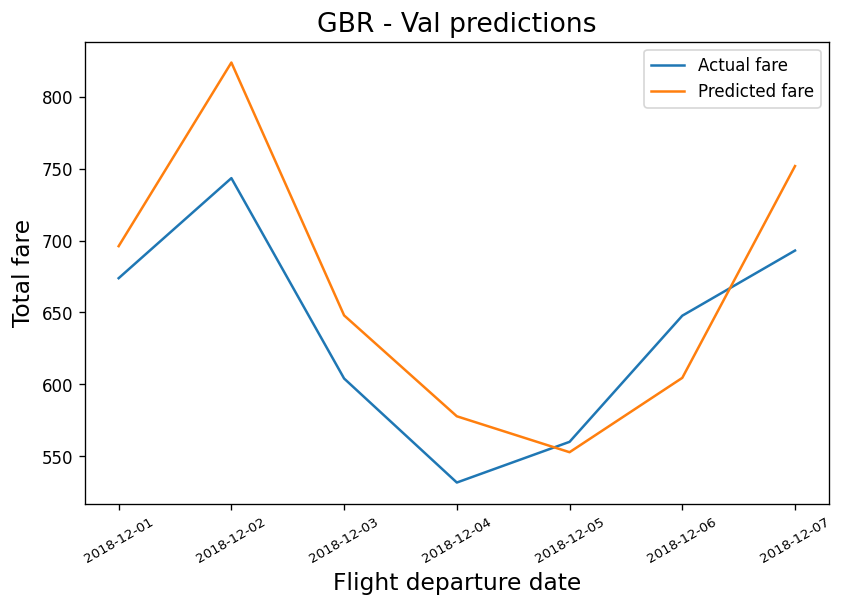

In [43]:
plt.figure(figsize = (8, 5), dpi = 120)
sns.lineplot(
    data = val_df.group_by('flt_departure_dt').agg(pl.col('total_fare').mean()), 
    x = "flt_departure_dt", 
    y = "total_fare",
    label = "Actual fare"
)

sns.lineplot(
    data = val_df.group_by('flt_departure_dt').agg(pl.col('pred_fare').mean()), 
    x = "flt_departure_dt", 
    y = "pred_fare",
    label = "Predicted fare"
)

locs, labels = plt.xticks()
plt.xticks(
    locs,
    [l.get_text() for l in labels],
    rotation = 30,
    fontsize = 8
)

plt.legend()
plt.title("GBR - Val predictions", fontsize = 16)
plt.xlabel("Flight departure date", fontsize = 14)
plt.ylabel("Total fare", fontsize = 14)
plt.show()

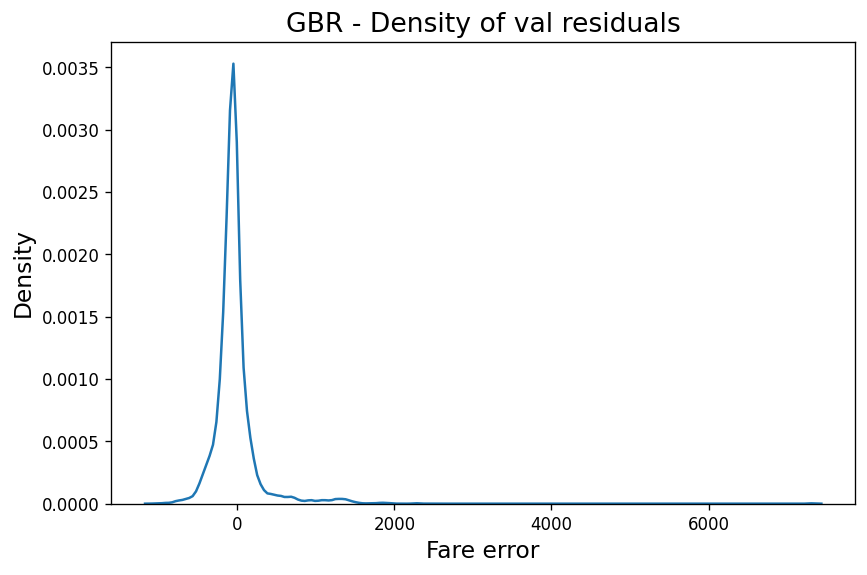

In [44]:
plt.figure(figsize = (8, 5), dpi = 120)
sns.kdeplot(
    val_df['total_fare'] - val_df['pred_fare']
)
plt.title("GBR - Density of val residuals", fontsize = 16)
plt.xlabel("Fare error", fontsize = 14)
plt.ylabel("Density", fontsize = 14)
plt.show()

### Metrics

#### Overall

In [45]:
print_metrics(
    train_df['total_fare'], train_df['pred_fare'],
    label = 'Train - GBR'
)

print_metrics(
    val_df['total_fare'], val_df['pred_fare'],
    label = 'Val - GBR'
)

Train - GBR
RMSE: 324.3798
MAE: 156.2625
R2: 51.557%
Max error: 5349.8381

Val - GBR
RMSE: 296.2643
MAE: 162.2268
R2: 51.847%
Max error: 7321.3755



#### By carrier

In [46]:
for carrier, df in train_df.group_by(['carrier']):
    print_metrics(
        df['total_fare'], df['pred_fare'],
        label = f'Val - Carrier {carrier[0]}'
    )

Val - Carrier U3
RMSE: 174.6003
MAE: 117.0481
R2: 29.273%
Max error: 1324.2239

Val - Carrier OTH
RMSE: 154.4804
MAE: 89.2614
R2: 59.760%
Max error: 1426.2325

Val - Carrier L3
RMSE: 433.1739
MAE: 243.6964
R2: 12.978%
Max error: 2125.0514

Val - Carrier U1
RMSE: 171.5753
MAE: 97.7006
R2: 64.697%
Max error: 1457.1596

Val - Carrier L1
RMSE: 369.7344
MAE: 185.7305
R2: 52.732%
Max error: 5349.8381

Val - Carrier L2
RMSE: 315.9585
MAE: 120.8453
R2: 50.674%
Max error: 4234.6431



In [47]:
for carrier, df in val_df.group_by(['carrier']):
    print_metrics(
        df['total_fare'], df['pred_fare'],
        label = f'Val - Carrier {carrier[0]}'
    )

Val - Carrier L1
RMSE: 268.1917
MAE: 179.7084
R2: 61.719%
Max error: 2558.4547

Val - Carrier U3
RMSE: 181.9219
MAE: 130.8621
R2: -432.798%
Max error: 591.3549

Val - Carrier L3
RMSE: 489.8773
MAE: 280.4268
R2: 12.392%
Max error: 1987.1045

Val - Carrier U1
RMSE: 148.4836
MAE: 103.2294
R2: 72.128%
Max error: 1058.8006

Val - Carrier L2
RMSE: 167.0693
MAE: 107.7207
R2: 79.891%
Max error: 2291.2357

Val - Carrier OTH
RMSE: 469.5526
MAE: 126.5230
R2: 14.637%
Max error: 7321.3755



#### By route

In [48]:
for route_id, df in train_df.group_by(['route_id']):
    print_metrics(
        df['total_fare'], df['pred_fare'],
        label = f'Val - Route {route_id[0]}'
    )

Val - Route 0
RMSE: 372.9809
MAE: 190.5064
R2: 33.062%
Max error: 4671.0631

Val - Route 3
RMSE: 322.9884
MAE: 200.3776
R2: 65.338%
Max error: 3699.5345

Val - Route 6
RMSE: 290.2993
MAE: 128.4736
R2: 22.801%
Max error: 4147.0707

Val - Route 9
RMSE: 350.4191
MAE: 164.4591
R2: 56.313%
Max error: 4030.2883

Val - Route 4
RMSE: 344.1222
MAE: 155.8250
R2: 20.733%
Max error: 4234.6431

Val - Route 10
RMSE: 339.0174
MAE: 165.3762
R2: 60.957%
Max error: 3527.6575

Val - Route 1
RMSE: 496.2161
MAE: 244.8044
R2: 35.631%
Max error: 4798.8304

Val - Route 7
RMSE: 397.8392
MAE: 194.7486
R2: 28.836%
Max error: 5349.8381

Val - Route 2
RMSE: 314.2664
MAE: 200.3059
R2: 60.282%
Max error: 4335.0057

Val - Route 11
RMSE: 242.5002
MAE: 123.6262
R2: 47.209%
Max error: 3686.7430

Val - Route 5
RMSE: 274.5072
MAE: 139.6230
R2: 51.885%
Max error: 3206.4001

Val - Route 8
RMSE: 540.2566
MAE: 286.3444
R2: 31.700%
Max error: 4624.5581



In [49]:
for route_id, df in val_df.group_by(['route_id']):
    print_metrics(
        df['total_fare'], df['pred_fare'],
        label = f'Val - Route {route_id[0]}'
    )

Val - Route 6
RMSE: 354.5555
MAE: 150.6395
R2: 17.079%
Max error: 7304.3440

Val - Route 0
RMSE: 224.7743
MAE: 161.3539
R2: 25.132%
Max error: 1005.9776

Val - Route 3
RMSE: 262.6364
MAE: 188.4083
R2: 71.220%
Max error: 1059.3702

Val - Route 9
RMSE: 129.1479
MAE: 99.8007
R2: 92.226%
Max error: 395.3674

Val - Route 1
RMSE: 260.1469
MAE: 190.0605
R2: -1.142%
Max error: 882.7333

Val - Route 4
RMSE: 359.9035
MAE: 174.8356
R2: 21.609%
Max error: 7321.3755

Val - Route 10
RMSE: 127.5997
MAE: 94.9096
R2: 92.152%
Max error: 680.4383

Val - Route 7
RMSE: 222.6836
MAE: 156.1755
R2: 14.179%
Max error: 1022.1092

Val - Route 2
RMSE: 458.8553
MAE: 328.3271
R2: 37.745%
Max error: 2558.4547

Val - Route 5
RMSE: 234.9499
MAE: 172.7725
R2: 57.752%
Max error: 2270.3040

Val - Route 11
RMSE: 118.2386
MAE: 90.9019
R2: 83.046%
Max error: 930.3414

Val - Route 8
RMSE: 315.6454
MAE: 256.3836
R2: -12.549%
Max error: 708.4974



### Feature importances

In [50]:
pl.DataFrame({
    "Feature": best_model['gbr'].feature_names_in_,
    "FI": (best_model['gbr'].feature_importances_ * 100).round(2)
}).sort("FI", descending = True)

Feature,FI
str,f64
"""remainder__days_till_flight""",27.85
"""remainder__14d_route_avg""",14.49
"""remainder__7d_route_carrier_av…",12.57
"""remainder__flt_count_dpt_24h""",9.43
"""remainder__dpt_4h_od""",6.5
"""remainder__7d_route_avg""",6.37
"""remainder__days_since_start""",6.17
"""remainder__flt_departure_weekd…",5.59
"""remainder__destination_id""",2.28
